# ai4 for health related matters

## dependencies

In [58]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## dataset stuff

### read the dataset

In [59]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
195,67,1,4,100,299,0,2,125,1,0.9,2,2.0,3.0,3
158,60,1,4,140,293,0,2,170,0,1.2,2,2.0,7.0,2
265,42,1,4,136,315,0,0,125,1,1.8,2,0.0,6.0,2
107,57,1,3,128,229,0,2,150,0,0.4,2,1.0,7.0,1
292,44,1,4,120,169,0,0,144,1,2.8,3,0.0,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,64,0,4,180,325,0,0,154,1,0.0,1,0.0,3.0,0
285,58,1,4,114,318,0,1,140,0,4.4,3,3.0,6.0,4
35,42,1,4,140,226,0,0,178,0,0.0,1,0.0,3.0,0
264,61,1,4,138,166,0,2,125,1,3.6,2,1.0,3.0,4


### train_test split

In [60]:
ratio = 0.9 # 90:10 train:test ratio
train_set = df.sample(frac=ratio)

# Dropping all those indexes from the dataframe that exists in the train_set
test_set = df.drop(train_set.index)
train_set.shape, test_set.shape

train_set
test_set

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
107,57,1,3,128,229,0,2,150,0,0.4,2,1.0,7.0,1
293,63,1,4,140,187,0,2,144,1,4.0,1,2.0,7.0,2
237,46,1,4,120,249,0,2,144,0,0.8,1,0.0,7.0,1
167,54,0,2,132,288,1,2,159,1,0.0,1,1.0,3.0,0
260,44,0,3,118,242,0,0,149,0,0.3,2,1.0,3.0,0
69,46,1,3,150,231,0,0,147,0,3.6,2,0.0,3.0,1
109,39,1,4,118,219,0,0,140,0,1.2,2,0.0,7.0,3
277,39,0,3,138,220,0,0,152,0,0.0,2,0.0,3.0,0
197,45,0,4,138,236,0,2,152,1,0.2,2,0.0,3.0,0
17,54,1,4,140,239,0,0,160,0,1.2,1,0.0,3.0,0


### formating

In [61]:
# import training dataset

# Clean column names
train_set.columns = train_set.columns.str.strip()

# Handle missing values represented by '?'
train_set = train_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
train_set = train_set.dropna()
train_set = train_set.astype(float)

# Split features and labels
X = train_set.drop("diagnosis", axis=1)
y = train_set["diagnosis"]

y = (y > 0.5).astype(float)  # Ensures only 0 or 1

# normalise featuress from minmax scaling (sklearn)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
inputs = torch.tensor(X_scaled, dtype=torch.float32)
targets = torch.tensor(y.values, dtype=torch.float32)

print(inputs.shape, targets.shape)

torch.Size([269, 13]) torch.Size([269])


In [62]:
# Clean column names
test_set.columns = test_set.columns.str.strip()

# Handle missing values represented by '?'
test_set = test_set.replace('?', np.nan)

# Convert columns to numeric, drop rows with NaNs
test_set = test_set.dropna()
test_set = test_set.astype(float)

# Split features and labels
X_test = test_set.drop("diagnosis", axis=1)
y_test = test_set["diagnosis"]
y_test = (y_test > 0.5).astype(float)  # Ensures only 0 or 1

# Use the same scaler as for training
X_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
test_tensor = torch.tensor(X_scaled, dtype=torch.float32)
test_target = torch.tensor(y_test.values, dtype=torch.float32)

print(test_tensor.shape, test_target.shape)

torch.Size([28, 13]) torch.Size([28])


## AI1

### setup/params

In [63]:
class SimpleNN(nn.Module): 
    def __init__(self): 
        super(SimpleNN, self).__init__() 
        self.fc1 = nn.Linear(13, 26)
        self.relu = nn.ReLU()
#        self.fc2 = nn.Linear(26, 32)
#        self.relu2 = nn.ReLU()
#        self.fc3 = nn.Linear(32, 26)
#        self.relu3 = nn.ReLU()
#        self.fc4 = nn.Linear(26, 1) #output layer
        self.fc2 = nn.Linear(26, 1)
        
    def forward(self, x): 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
#        x = self.relu2(x)
#        x = self.fc3(x)
#        x = self.relu3(x)
#        x = self.fc4(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss

model = SimpleNN()
print(model)

SimpleNN(
  (fc1): Linear(in_features=13, out_features=26, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=26, out_features=1, bias=True)
)


### error calcs.

In [64]:
#calculate error
# Use BCEWithLogitsLoss for binary classification
criterion = nn.BCEWithLogitsLoss()
optimiser = optim.SGD(model.parameters(), lr=0.01)

# Ensure targets are shape (N, 1)
targets = targets.view(-1, 1)
print(targets)

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
      

### training

In [65]:
# learning rate
lr = 0.001

Epoch [1/5000], Loss: 0.7088
Epoch [2/5000], Loss: 0.7087
Epoch [3/5000], Loss: 0.7085
Epoch [4/5000], Loss: 0.7083
Epoch [5/5000], Loss: 0.7082
Epoch [6/5000], Loss: 0.7080
Epoch [7/5000], Loss: 0.7079
Epoch [8/5000], Loss: 0.7077
Epoch [9/5000], Loss: 0.7076
Epoch [10/5000], Loss: 0.7074
Epoch [11/5000], Loss: 0.7073
Epoch [12/5000], Loss: 0.7071
Epoch [13/5000], Loss: 0.7070
Epoch [14/5000], Loss: 0.7068
Epoch [15/5000], Loss: 0.7067
Epoch [16/5000], Loss: 0.7065
Epoch [17/5000], Loss: 0.7064
Epoch [18/5000], Loss: 0.7062
Epoch [19/5000], Loss: 0.7061
Epoch [20/5000], Loss: 0.7059
Epoch [21/5000], Loss: 0.7058
Epoch [22/5000], Loss: 0.7056
Epoch [23/5000], Loss: 0.7055
Epoch [24/5000], Loss: 0.7053
Epoch [25/5000], Loss: 0.7052
Epoch [26/5000], Loss: 0.7051
Epoch [27/5000], Loss: 0.7049
Epoch [28/5000], Loss: 0.7048
Epoch [29/5000], Loss: 0.7046
Epoch [30/5000], Loss: 0.7045
Epoch [31/5000], Loss: 0.7043
Epoch [32/5000], Loss: 0.7042
Epoch [33/5000], Loss: 0.7041
Epoch [34/5000], Lo

Epoch [90/5000], Loss: 0.6968
Epoch [91/5000], Loss: 0.6966
Epoch [92/5000], Loss: 0.6965
Epoch [93/5000], Loss: 0.6964
Epoch [94/5000], Loss: 0.6963
Epoch [95/5000], Loss: 0.6962
Epoch [96/5000], Loss: 0.6960
Epoch [97/5000], Loss: 0.6959
Epoch [98/5000], Loss: 0.6958
Epoch [99/5000], Loss: 0.6957
Epoch [100/5000], Loss: 0.6956
Epoch [101/5000], Loss: 0.6955
Epoch [102/5000], Loss: 0.6953
Epoch [103/5000], Loss: 0.6952
Epoch [104/5000], Loss: 0.6951
Epoch [105/5000], Loss: 0.6950
Epoch [106/5000], Loss: 0.6949
Epoch [107/5000], Loss: 0.6948
Epoch [108/5000], Loss: 0.6946
Epoch [109/5000], Loss: 0.6945
Epoch [110/5000], Loss: 0.6944
Epoch [111/5000], Loss: 0.6943
Epoch [112/5000], Loss: 0.6942
Epoch [113/5000], Loss: 0.6941
Epoch [114/5000], Loss: 0.6940
Epoch [115/5000], Loss: 0.6939
Epoch [116/5000], Loss: 0.6937
Epoch [117/5000], Loss: 0.6936
Epoch [118/5000], Loss: 0.6935
Epoch [119/5000], Loss: 0.6934
Epoch [120/5000], Loss: 0.6933
Epoch [121/5000], Loss: 0.6932
Epoch [122/5000], 

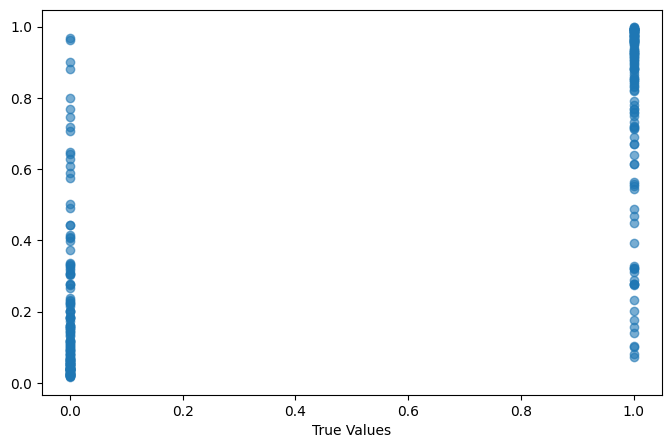

In [ ]:
for epoch in range(10000):sdasffgfd,djh,



optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
#    if (epoch + 1) % 500 == 0:
    print(f'Epoch [{epoch + 1}/5000], Loss: {loss.item():.4f}')
print(outputs)

# Evaluate on training set
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.sigmoid(outputs)
    predicted_classes = (preds > 0.5).float()
    accuracy = (predicted_classes == targets).float().mean()
    print(f"Training Accuracy: {accuracy.item()*100:.2f}%")

    # Plot predictions vs. true values
    plt.figure(figsize=(8, 5))
    plt.scatter(targets.numpy(), preds.numpy(), alpha=0.6)
    plt.xlabel("True Values")

### testing

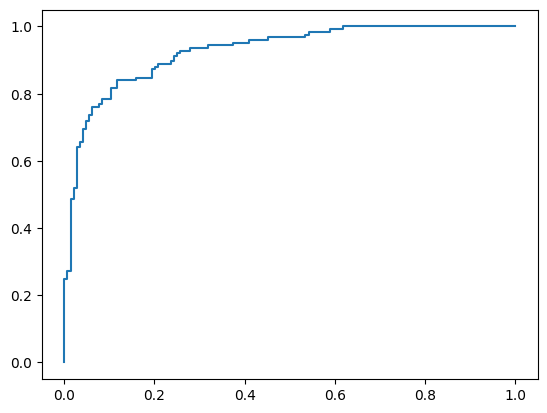

In [67]:
# roc curve
fpr, tpr, _ = roc_curve(targets.numpy(), preds.numpy())
plt.plot(fpr, tpr, label = "ROC Curve")

## UI